In [1]:
import eli5
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OrdinalEncoder
from eli5.sklearn import PermutationImportance
from ipywidgets import interact, fixed
from joblib import dump, load
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.utils.multiclass import unique_labels
from xgboost import XGBRFClassifier, XGBClassifier
from jupyterthemes import jtplot

In [2]:
pd.__version__

'0.24.2'

In [3]:
%matplotlib inline
jtplot.style(grid=False)
pd.set_option('display.max_columns', 50)

In [6]:
%run -i main.py

In [7]:
df = pd.read_csv('model/model_data.csv').set_index('index')

In [8]:
df.head()

,Age,Race,Income,Over Median Income,Ownership,Total Household,Employment,Active,Overweight,Diabetic,Good Health,Fruit,Vegetables,Sleep Hrs,Insurance,Dr Too Much,Recent Dr Visit,Smoker,Alcohol
index,,,,,,,,,,,,,,,,,,,
41694,80-84,White,$20-25K,False,Own,1.0,Unknown,Unknown,Over,False,Good,Unknown,Unknown,10.0,Unknown,No,Past Year,Never Smoked,30
49527,25-29,Hisp.,Unknown,False,Rent,3.0,Unknown,Unknown,Obese,False,Fair,Unknown,Unknown,6.0,Yes,No,1-2 years,Never Smoked,2
64569,35-39,White,$35-50K,False,Rent,3.0,Unknown,Unknown,Over,False,Very Good,Monthly,Monthly,NaN,Yes,No,1-2 years,Former Smoker,3
5458,25-29,Hisp.,$25-35K,False,Rent,3.0,Employed for wages,Does not meet Aerobic Recs,Obese,False,Fair,Monthly,Monthly,NaN,Yes,No,Past Year,Never Smoked,5
59335,40-44,White,$75+,True,Rent,2.0,Unknown,Unknown,Obese,False,Excellent,Weekly,Monthly,NaN,Yes,No,1-2 years,Never Smoked,4


In [9]:
def train_val_test_split(X, y):
    trainval, test, y_trainval, y_test = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          random_state=42,
                                                          )
    train, val, y_train, y_val = train_test_split(trainval,
                                                  y_trainval,
                                                  stratify=y_trainval,
                                                  random_state=42)
    return train, val, test, y_train, y_val, y_test

In [10]:
df['Over Median Income'].value_counts().index

Index([False, True], dtype='object')

In [11]:
target = 'Diabetic'
y = df[target].astype(bool)
X = df.drop(columns=target)

In [12]:
train, val, test, y_train, y_val, y_test = train_val_test_split(X, y)
train.shape, val.shape, test.shape, y_train.shape, y_val.shape, y_test.shape

((41559, 18), (13854, 18), (18472, 18), (41559,), (13854,), (18472,))

In [13]:
# Predict majority class as baseline.
y.value_counts(normalize=True)

False    0.889071
True     0.110929
Name: Diabetic, dtype: float64

In [14]:

roc_auc_score(y_train, np.full(y_train.shape, 0))

0.5

In [15]:
pipeline = make_pipeline(OrdinalEncoder(),
                         SimpleImputer())

In [16]:
X_train = pipeline.fit_transform(train)
X_val = pipeline.transform(val)
X_test = pipeline.transform(test)
X_train.shape, X_val.shape, X_test.shape

((41559, 18), (13854, 18), (18472, 18))

In [17]:
eval_set = [(X_train, y_train),
            (X_val, y_val)]

In [18]:
model = XGBRFClassifier(n_jobs=-1,
                        n_estimators=5000,
                        early_stopping_rounds=100,
                        random_state=42,
                        scale_pos_weight=15,
                        learning_rate=.005,
                        reg_lambda=.01,
                        verbosity=1)

In [19]:
model.fit(X_train,
          y_train,
          eval_set=eval_set,
          eval_metric='auc',
          verbose=True)

[0]	validation_0-auc:0.785672	validation_1-auc:0.773351


XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, early_stopping_rounds=100, gamma=0,
                learning_rate=0.005, max_delta_step=0, max_depth=3,
                min_child_weight=1, missing=None, n_estimators=5000, n_jobs=-1,
                nthread=None, objective='binary:logistic', random_state=42,
                reg_alpha=0, reg_lambda=0.01, scale_pos_weight=15, seed=None,
                silent=None, subsample=0.8, verbosity=1)

Validation ROC AUC score: 0.7733511120699031


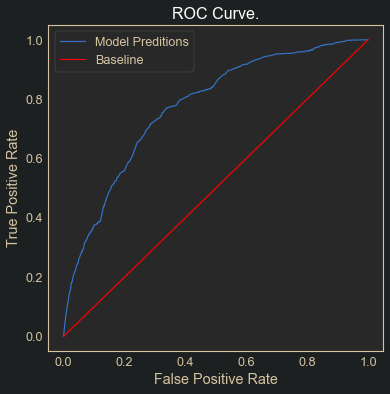

In [20]:
y_pred_proba = model.predict_proba(X_val)[:, 1]
print(f'Validation ROC AUC score: {roc_auc_score(y_val, y_pred_proba)}')
curves = roc_curve(y_val, y_pred_proba)
curve_x, curve_y = curves[0], curves[1]
x_ = np.linspace(0, 1, len(curve_x))
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()
y_ = x_
plt.plot(curve_x, curve_y, label='Model Preditions')
plt.plot(x_, y_, color='red', label='Baseline')
plt.title('ROC Curve.',
          fontsize=16,
          color='white')
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.legend();

In [21]:
permuter = PermutationImportance(model,
                                 cv='prefit',
                                 n_iter=5,
                                 scoring='roc_auc',
                                 random_state=42)
permuter.fit(X_val, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBRFClassifier(base_score=0.5,
                                                colsample_bylevel=1,
                                                colsample_bynode=0.8,
                                                colsample_bytree=1,
                                                early_stopping_rounds=100,
                                                gamma=0, learning_rate=0.005,
                                                max_delta_step=0, max_depth=3,
                                                min_child_weight=1,
                                                missing=None, n_estimators=5000,
                                                n_jobs=-1, nthread=None,
                                                objective='binary:logistic',
                                                random_state=42, reg_alpha=0,
                                                reg_lambda=0.01,
                    

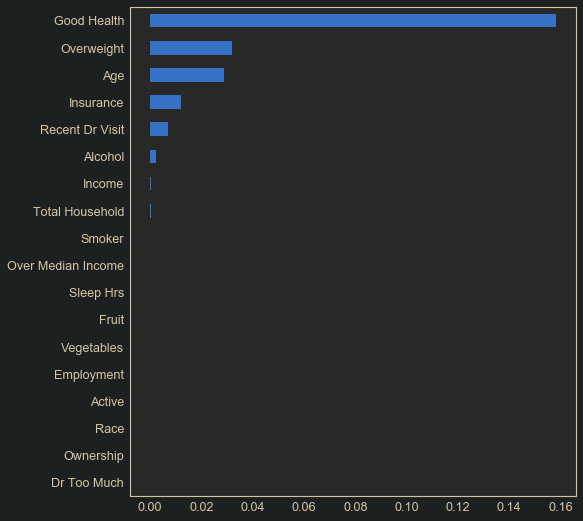

In [22]:
features_of_import = pd.Series(permuter.feature_importances_, val.columns)
plt.figure(figsize=(8, len(val.columns) / 2))
features_of_import.sort_values(ascending=True).plot.barh();

In [23]:
mask = features_of_import > 0
trimmed_columns = train.columns[mask]
train_trimmed = train[trimmed_columns]
val_trimmed = val[trimmed_columns]
test_trimmed = test[trimmed_columns]

pipeline1 = make_pipeline(OrdinalEncoder(),
                          SimpleImputer())

X_train_ = pipeline1.fit_transform(train_trimmed)
X_val_ = pipeline1.transform(val_trimmed)
X_test_ = pipeline1.transform(test_trimmed)

eval_set1 = [(X_train_, y_train),
            (X_val_, y_val)]

In [24]:
model.fit(X_train_, y_train, eval_set=eval_set1, eval_metric='auc')
y_pred_proba = model.predict_proba(X_val_)[:, 1]
print(f'XGBRFClassifier validation ROC AUC: {roc_auc_score(y_val, y_pred_proba)}')

[0]	validation_0-auc:0.783355	validation_1-auc:0.770201
XGBRFClassifier validation ROC AUC: 0.7702009468059364


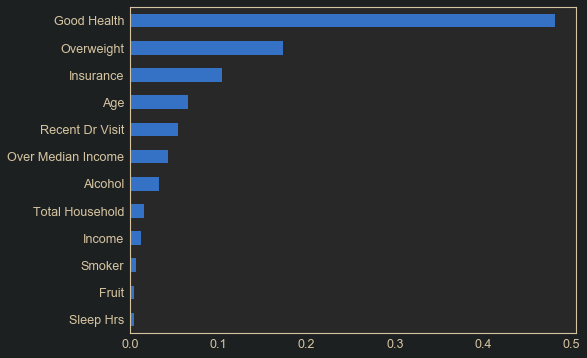

In [25]:
importance = pd.Series(model.feature_importances_, val_trimmed.columns)
plt.figure(figsize=(8, len(val_trimmed.columns) / 2))
importance.sort_values(ascending=True).plot.barh()

In [26]:
# params = {'n_estimators': [100, 500, 1000, 5000, 10000],
#           'scale_pos_weights': [1, 5, 10, 15, 20],
#           'learning_rate': [.0001, .001, .01, .02, .05],
#           'reg_lambda': [.0001, .001, .01, .02, .05]}
# search = RandomizedSearchCV(model,
#                             param_distributions=params,
#                             scoring='roc_auc',
#                             n_iter=50,
#                             cv=5,
#                             n_jobs=-1)
# search.fit(X_train_, y_train)
# search.best_estimator_, search.best_params_, search.best_score_

In [27]:
best = XGBRFClassifier(scale_pos_weights=20,
                       reg_lambda=0.02,
                       n_estimators=10000,
                       learning_rate=0.05,
                       n_jobs=-1,
                       early_stopping_rounds=100,
                       random_state=42,
                       verbosity=1)
best.fit(X_train_, y_train)
y_pred_proba1 = best.predict_proba(X_val_)[:, 1]

In [28]:
# best = search.best_estimator_
# y_pred_proba1 = best.predict_proba(X_val_)[:, 1]

In [29]:
def nice_confusion(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                         columns=columns,
                         index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='copper_r')

In [31]:
def set_threshold(y_true, y_pred_proba, threshold=.48):
    
    print(f'Threshold: {threshold}')
    
    # Apply threshold to probabilies of positive prediction.
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1

    # Plot distribution of predicted probabilities.
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='r')
    plt.title('Distribution of predicted probabilities')
    plt.show()
    
    # Calculate true positive and false positive rates.
    true_pos = (y_pred == y_true) & (y_pred == class_1)
    false_pos = (y_pred != y_true) & (y_pred == class_1)
    actual_pos = y_true == class_1
    actual_neg = y_true == class_0
    true_pos_rate = true_pos.sum() / actual_pos.sum()
    false_pos_rate = false_pos.sum() / actual_neg.sum()
    print(f'True Positive Rate: {true_pos_rate:.4f}')
    print(f'False Positive Rate: {false_pos_rate:.4f}')
    
    # Plot ROC curve.
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC Curve')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    # Plot point for current threshold.
    plt.scatter(false_pos_rate, true_pos_rate)
    plt.show()
    
    print(f'Area under ROC: {roc_auc_score(y_true, y_pred_proba):.4f}')
    
    nice_confusion(y_true, y_pred)
    print(classification_report(y_true, y_pred))


In [32]:
interact(set_threshold,
        y_true=fixed(y_val),
        y_pred_proba=fixed(y_pred_proba1),
        threshold=(0.47, 0.5, 0.0001));

interactive(children=(FloatSlider(value=0.48, description='threshold', max=0.5, min=0.47, step=0.0001), Output…

Test time!!

In [33]:

test_pred_proba = best.predict_proba(X_test_)[:, 1] > 0.48
print(f'Test ROC AUC: {roc_auc_score(y_test, test_pred_proba)}')

Test ROC AUC: 0.6925781870923621


Find individual instances to examine.

In [34]:
test_trimmed1 = pd.concat([test_trimmed, y_test], axis=1, sort=False)
test_trimmed1.tail(20)

,Age,Income,Over Median Income,Total Household,Overweight,Good Health,Fruit,Sleep Hrs,Insurance,Recent Dr Visit,Smoker,Alcohol,Diabetic
index,,,,,,,,,,,,,
54070,25-29,Refused,False,4.0,Over,Good,Daily,NaN,Yes,1-2 years,Never Smoked,1,False
71502,70-74,Refused,False,1.0,Normal,Good,Unknown,8.0,Unknown,Past Year,Current - Every Day,8,True
89244,60-64,$50-75K,False,2.0,Over,Excellent,Weekly,NaN,Yes,Past Year,Never Smoked,Unknown,False
15372,80-84,$20-25K,False,1.0,Normal,Fair,Unknown,NaN,Unknown,Past Year,Never Smoked,30,False
22160,60-64,$50-75K,False,2.0,Obese,Good,Unknown,NaN,Yes,Past Year,Former Smoker,Unknown,True
2266,55-59,$50-75K,False,2.0,Over,Very Good,Daily,NaN,Yes,2-5 years,Never Smoked,30,False
13484,30-34,$35-50K,False,3.0,Unknown,Excellent,Weekly,NaN,Yes,1-2 years,Never Smoked,Unknown,False
28437,30-34,< $10K,False,1.0,Normal,Very Good,Unknown,NaN,No,5+ years,Former Smoker,Unknown,False
34222,65-69,$75+,True,2.0,Normal,Good,Daily,6.0,Unknown,Past Year,Never Smoked,Unknown,False


In [35]:
data = test_trimmed1[test_trimmed1.index == 22160]
data_ = data.drop(columns='Diabetic')
data_ = pipeline1.transform(data_)
print(model.predict(data_)[0], best.predict_proba(data_)[:, 1][0] > 0.48, best.predict_proba(data_)[:, 1][0])
data

True True 0.4822771


,Age,Income,Over Median Income,Total Household,Overweight,Good Health,Fruit,Sleep Hrs,Insurance,Recent Dr Visit,Smoker,Alcohol,Diabetic
index,,,,,,,,,,,,,
22160,60-64,$50-75K,False,2.0,Obese,Good,Unknown,NaN,Yes,Past Year,Former Smoker,Unknown,True


In [36]:
data = test_trimmed1[test_trimmed1.index == 82568]
data_ = data.drop(columns='Diabetic')
data_ = pipeline1.transform(data_)
print(model.predict(data_)[0], best.predict_proba(data_)[:, 1][0] > 0.48, best.predict_proba(data_)[:, 1][0])
data

True False 0.47905847


,Age,Income,Over Median Income,Total Household,Overweight,Good Health,Fruit,Sleep Hrs,Insurance,Recent Dr Visit,Smoker,Alcohol,Diabetic
index,,,,,,,,,,,,,
82568,70-74,$75+,True,2.0,Normal,Very Good,Daily,NaN,Unknown,Past Year,Former Smoker,28,True


In [37]:
data = test_trimmed1[test_trimmed1.index == 65666]
data_ = data.drop(columns='Diabetic')
data_ = pipeline1.transform(data_)
print(model.predict(data_)[0], best.predict_proba(data_)[:, 1][0] > 0.48, best.predict_proba(data_)[:, 1][0])
data

True True 0.49140975


,Age,Income,Over Median Income,Total Household,Overweight,Good Health,Fruit,Sleep Hrs,Insurance,Recent Dr Visit,Smoker,Alcohol,Diabetic
index,,,,,,,,,,,,,
65666,40-44,$15-20K,False,4.0,Obese,Fair,None,NaN,Yes,2-5 years,Current - Every Day,Unknown,False


 Start building mechanism to choose parameters for custom predictions.

In [39]:
dump(pipeline1, 'pipeline.joblib')
dump(best, 'estimator.joblib')
dump(test_trimmed.columns, 'columns.joblib')
# df.to_csv('data/model_data.csv')


['columns.joblib']

In [40]:
test_trimmed.columns

Index(['Age', 'Income', 'Over Median Income', 'Total Household', 'Overweight',
       'Good Health', 'Fruit', 'Sleep Hrs', 'Insurance', 'Recent Dr Visit',
       'Smoker', 'Alcohol'],
      dtype='object')

In [50]:
test_trimmed['Alcohol'].value_counts()

Unknown    7271
1          1455
4          1271
2          1043
30         1030
8           820
20          804
3           640
12          622
5           569
10          446
28          428
15          411
16          295
25          252
6           236
7           155
24          118
0            45
14           32
29           19
18           16
26           14
9            13
27           12
22            9
21            7
13            7
17            6
11            5
23            4
19            3
Name: Alcohol, dtype: int64

In [57]:
column_values = {'Age': list(sorted(test_trimmed['Age'].value_counts().index.tolist())),
                 'Income': ['< $10K', 
                            '$10-15K', 
                            '$15-20K', 
                            '$20-25K', 
                            '$25-30K', 
                            '$30-35K',
                            '$35-40K',
                            '$40-45K',
                            '$45-50K',
                            '$50-55K',
                            '$55-60K',
                            '$60-65K',
                            '$65-70K',
                            '$75+',
                            'Unknown'
                           ],
                 'Over Median Income': ['True',
                                        'False'],
                 'Total Household': list(sorted(test_trimmed['Total Household'].value_counts().index.tolist())),
                 'Overweight': ['Under',
                                'Normal',
                                'Over',
                                'Obese',
                                'Unknown'],
                 'Good Health': ['Excelent',
                                 'Very Good',
                                 'Good',
                                 'Fair',
                                 'Poor',
                                 'Unknown'],
                 'Fruit': ['Daily',
                           'Weekly',
                           'Monthly',
                           'None',
                           'Unknown'],
                 'Sleep Hrs': list(sorted(test_trimmed['Sleep Hrs'].value_counts().index.tolist())),
                 'Insurance': ['Yes',
                               'No',
                               'Unknown'],
                 'Recent Dr Visit': test_trimmed['Recent Dr Visit'].value_counts().index.tolist(),
                 'Smoker': test_trimmed['Smoker'].value_counts().index.tolist(),
                 'Alcohol': list(sorted(test_trimmed['Alcohol'].value_counts().index.tolist()))
                 }
dump(column_values, 'column_values.joblib')
# column_values

['column_values.joblib']

In [56]:
columns = list(column_values.keys())
print(column_values['Over Median Income'])
columns

['False', 'True']


['Age',
 'Income',
 'Over Median Income',
 'Total Household',
 'Overweight',
 'Good Health',
 'Fruit',
 'Sleep Hrs',
 'Insurance',
 'Recent Dr Visit',
 'Smoker',
 'Alcohol']